In [461]:
import pandas as pd
from tqdm import tqdm
from top2vec import Top2Vec
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from pathlib import Path
import yaml 
import os
import matplotlib
import igraph
from collections import Counter
import networkx as nx
from sklearn import preprocessing

from helpers.linkage import *
from helpers import dataloader
from helpers.afa import adaptive_filter
from helpers.visuals import add_cabinet_periods
from helpers import metrics as mc
from helpers import infodynamics
import seaborn as sns
from helpers.networks import *
import helpers.linkage as lkg
from helpers import style 
from helpers import metrics as mc
from helpers import infodynamics
from helpers.infodynamics import diachronic_correlations_lookback

style.load_style()

cf = yaml.safe_load(Path('config.yml').read_text())

In [4]:
data = dataloader.load(cf,agg_level='speech',model_type='lda')
dists = data['dists']
labels = data['labels']
words = data['words']

dists = dists[(dists.index.year > 1945) & (dists.index.year < 1967)]

# Load merged cabinet metadata
cab_ = pd.read_csv('helpers/cabinets-merged.csv',sep='\t')
cab_['startdate'] = pd.to_datetime(cab_.startdate,infer_datetime_format=True)
cab_['enddate'] = pd.to_datetime(cab_.enddate,infer_datetime_format=True)

indices_nonsem = [k for k,v in labels.items() if 'rhet' in v or 'proc' in v]
labels_reverse =dict(zip(labels.values(),labels.keys()))

/tmp/ipykernel_4097/283382609.py:11: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  cab_['enddate'] = pd.to_datetime(cab_.enddate,infer_datetime_format=True)


# Plot top betweenness and degree scores on scatter

/tmp/ipykernel_1280/2047360978.py:6: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  cab_['enddate'] = pd.to_datetime(cab_.enddate,infer_datetime_format=True)


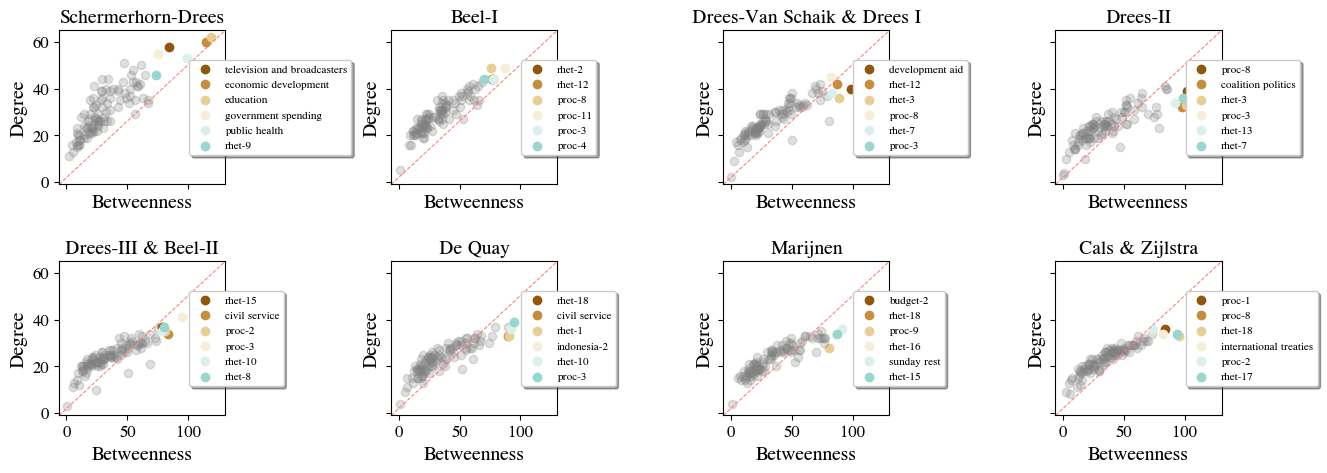

In [14]:
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

cab_ = pd.read_csv('helpers/cabinets-merged.csv',sep='\t')
cab_['startdate'] = pd.to_datetime(cab_.startdate,infer_datetime_format=True)
cab_['enddate'] = pd.to_datetime(cab_.enddate,infer_datetime_format=True)

fig,axs = plt.subplots(2,4,figsize=(15,5),sharey=True,sharex=True)
axs = axs.flatten()

for c,(i,r) in enumerate(cab_.iterrows()):
    mask = (dists.index > r['startdate']) & (dists.index <= r['enddate'])
    theta = dists.loc[mask].to_numpy()
    theta,_,__ = mutual_information(theta)

    g,cmty,fmx = get_network_from_mi_theta(theta,thr=0)
    btw_vals = dict(get_betweenness_values(g))
    deg_vals = dict(get_degree_values(g))

    top_btw = [k for k,v in Counter(btw_vals).most_common(6)]
    top_deg = [k for k,v in Counter(btw_vals).most_common(6)]
    top = set(top_btw + top_deg)

    xmin,xmax = axs[c].get_xlim()
    ymin,ymax = axs[c].get_ylim()

    top_pal = sns.color_palette('BrBG',8)
    cc = 0
    for topic in deg_vals.keys():
        
        if topic in top:
            lab = labels[topic]
            axs[c].scatter([btw_vals[topic]],[deg_vals[topic]],color=top_pal[cc],alpha=1,label=lab)
            cc += 1
        if topic not in top:
            axs[c].scatter([btw_vals[topic]],[deg_vals[topic]],alpha=.25,color='grey')

    axs[c].set_title(r['cabinet'],fontsize=14)
    axs[c].set_ylabel('Degree')
    axs[c].set_xlabel('Betweenness')
    axs[c].legend(loc='center left', bbox_to_anchor=(.75, 0.5),ncol=1, fancybox=True, shadow=True,fontsize=8)

    line = mlines.Line2D([0, 1], [0, 1], color='salmon',linewidth=.75,linestyle='--')
    transform = axs[c].transAxes
    line.set_transform(transform)
    axs[c].add_line(line)   

plt.subplots_adjust(hspace=.5,wspace=1)
# plt.savefig('figs/networks-cabinets-betweenness-degree.pdf',dpi=250)
plt.show()

# Calculate Diachronic Betweenness / Degree for Topics

In [734]:
# Define helper functions
min_max_scaler = preprocessing.MinMaxScaler()

def mm_scaler(a):
    return np.squeeze(np.asarray(min_max_scaler.fit_transform(np.array(a).reshape(-1,1))))

def get_timeseries(rd,dg,target_metric,topic_label,axs,rolling=True,plot=False,color=''):
    """ 
    Function for calculating (smoothed) timeseries for prominence and degree per topic
    rd: DF with columns "topic", "btw", "deg", and "date"
    dg: DF with rows as averaged topic distributions per time period (Q)
    target metric: btw or degree
    rolling: rolling mean
    plot: plot time series
    """
    target_metric_fancy = 'Degree' if target_metric == 'deg' else 'Betweenness'

    target_rd = rd.query(f'top == "{topic_label}"').drop(columns='top').set_index('date').drop(columns=['btw'] if target_metric == 'deg' else ['deg'])
    target_rd['topic_prominence'] = dg[[k for k,v in labels.items() if v == f'{topic_label}'][0]]
    
    if rolling == True:
        target_rd = target_rd.rolling(8,center=True).mean().dropna()
    # target_rd = target_rd[[target_metric,'topic_prominence']].apply(mm_scaler)

    target_rd['norm_tgm'] = target_rd[target_metric] / target_rd.topic_prominence
    target_rd.columns = [f'Normalized {target_metric_fancy}','Topic Prominence',f'Prominence-Normalized {target_metric_fancy}']

    if plot == True:
        for c,col in enumerate(target_rd.columns):
            axs[c].plot(target_rd.index.to_timestamp(),target_rd[col],color=color)
            axs[c].set_title(col)
        return target_rd
    else:
        return target_rd

In [671]:
# Create a DF with the mean topic prominence per quarter
dg = dists.groupby(dists.index.to_period('Q')).mean()

# Loop over quarters, get networks (with a dis_filter of .75) and extract per-node betweenness and degree
r = []
for c,(date,dist_subset) in enumerate(dists.groupby(dists.index.to_period('Q'))):
    g,comm,edge_df = get_network_from_mi_theta(mi_theta=dist_subset.to_numpy(),weight_threshold=0,dis_filter=.5,labels=labels,node_text='labels')
    btw = dict(get_betweenness_values(g))
    deg = dict(get_degree_values(g))
    av_degree = igraph.mean(g.degree())
    r += [{"top":l,"btw":btw[l],"deg":deg[l] / av_degree,"date":date} for l in btw.keys()]
rd = pd.DataFrame(r)

# For the per-node degree scores, calculate the zscores for their time series
# Find the max zscore per topic, this might indicate burstiness
top_pol = rd.drop(columns=['btw']).pivot(index='date',columns='top',values='deg').fillna(0.0)
top_pol = pd.DataFrame(np.apply_along_axis(zscore,0,top_pol),index=top_pol.index,columns=top_pol.columns).max().reset_index()
top_pol.columns = ['topic','ts_z_max']

# Additionally, calculate the correlation between the topic degree time series and topic prominence time series
# Non-correlating topics could point towards asynchronicity between prominence and degree
stats = []
for l in tqdm(labels.values()):
    r_ = get_timeseries(rd=rd,dg=dg,target_metric='deg',topic_label=l,plot=False)
    r_c = r_.corr()
    cor_ = r_c.iloc[0,1]
    stats.append({"topic":l,"ndegree-topic correlation":cor_})
stats = pd.DataFrame(stats)
top_pol = pd.merge(top_pol, stats, on='topic',how='outer')

/home/rb/Documents/GitHub/linkage/helpers/networks.py:176: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  table = table.drop("edge", 1)
/home/rb/Documents/GitHub/linkage/helpers/networks.py:177: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  table = table.drop("score_min", 1)
/home/rb/Documents/GitHub/linkage/helpers/networks.py:178: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  table = table.drop("variance_max", 1)
/home/rb/Documents/GitHub/linkage/helpers/networks.py:176: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  table = table.drop("edge", 1)
/home/rb/Documents/GitHub/linkage/helpers/networks.py:177: FutureWarning: In a future version o

In [672]:
# Interesting topics are likely to have high max zscores, but low degree-topic correlation.
# To get them, I divide the max zscores by the correlation coefficients, then sort the df

top_pol['norm_zm'] = top_pol.ts_z_max / top_pol['ndegree-topic correlation']
top_pol.sort_values('norm_zm',ascending=False).head(15)

,topic,ts_z_max,ndegree-topic correlation,norm_zm
84,rhet-6,1.994267,0.006744,295.706625
22,european integration-2,3.246245,0.024582,132.059011
96,traffic and infrastructure,4.162342,0.073860,56.354658
56,proc-13,7.028891,0.129050,54.466315
26,fisheries,3.864279,0.071470,54.068308
42,municipal finance,5.345548,0.138299,38.652075
92,sunday rest,3.710157,0.121664,30.495000
15,defense and conscription,4.303535,0.185279,23.227333
54,proc-11,3.864580,0.239946,16.106015
58,proc-3,2.858097,0.186554,15.320486


In [696]:
top_pol.sort_values('ndegree-topic correlation',ascending=False).head(15)

,topic,ts_z_max,ndegree-topic correlation,norm_zm
79,rhet-18,3.764467,0.985615,3.819410
80,rhet-2,1.956717,0.965866,2.025869
18,education,6.585185,0.952650,6.912490
73,rhet-12,2.495075,0.945011,2.640260
27,government spending,6.260382,0.936785,6.682835
10,committee appointments,7.179645,0.934358,7.684038
11,communism and democracy,3.024694,0.915048,3.305504
4,budget-2,3.165004,0.896396,3.530810
16,development aid,3.761418,0.889850,4.227027
21,european integration-1,3.480800,0.881979,3.946579


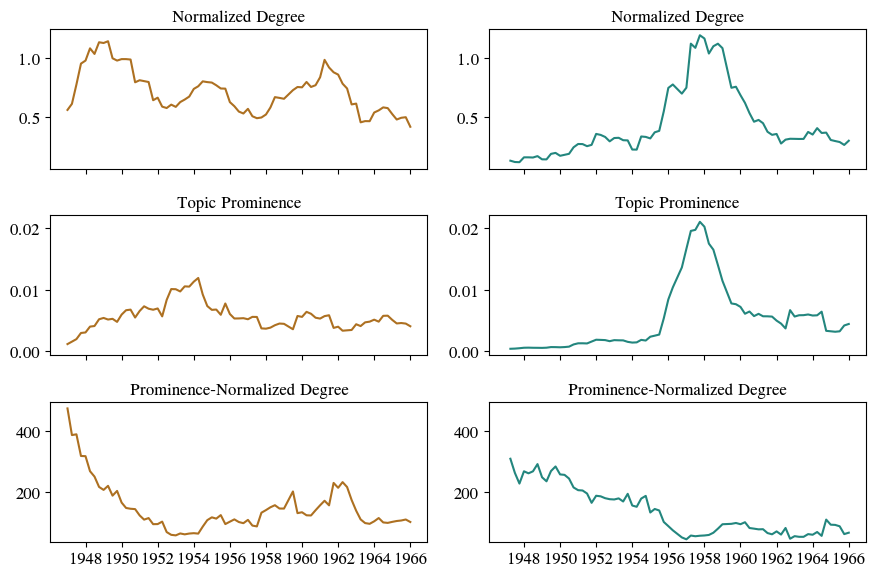

In [740]:
# Then, I use the plotting function to show the asynchronicity between degree and prominence
fig,axs = plt.subplots(3,2,sharex=True,figsize=(9,6))

c1,c2 = sns.color_palette('BrBG',5)[0],sns.color_palette('BrBG',5)[-1]
tn = get_timeseries(rd=rd,dg=dg,target_metric='deg',axs=[axs[i,0] for i in range(3)],topic_label='european integration-2',plot=True,color=c1)
tn = get_timeseries(rd=rd,dg=dg,target_metric='deg',axs=[axs[i,1] for i in range(3)],topic_label='government spending',plot=True,color=c2)

tps = ['European Integration-2','Government Spending']

axs[0,0].set_ylim(axs[0,1].get_ylim())
axs[1,0].set_ylim(axs[1,1].get_ylim())
axs[2,1].set_ylim(axs[2,0].get_ylim())

fig = plt.gcf()
# fig.suptitle(f'Degree, Prominence and PN Degree Time Series\n for Topics: {tps[0]} (Left) and {tps[1]} (Right)',fontsize=16)
fig.tight_layout()
plt.savefig('figs/degree-burst-prominence-examples.pdf',dpi=250)
plt.show()